# Project 3

In this project, you will perform a logistic regression on admissions data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import pylab as pl
import numpy as np

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
df = pd.read_csv("../assets/admissions.csv")
df.head()

,admit,gre,gpa,prestige
0,0,380.0,3.61,3.0
1,1,660.0,3.67,3.0
2,1,800.0,4.00,1.0
3,1,640.0,3.19,4.0
4,0,520.0,2.93,4.0


In [3]:
df.isnull().sum()

admit       0
gre         2
gpa         2
prestige    1
dtype: int64

In [4]:
df[df.isnull().any(axis=1)] 

#isnull retruns true or falses, and any returns the row if any one of the cells is T or F. 
#fyi .all also returns the row if all the cells = true or false

,admit,gre,gpa,prestige
187,0,NaN,NaN,2.0
212,0,NaN,2.87,2.0
236,1,660.0,NaN,NaN


In [5]:
df.admit.value_counts()

0    273
1    127
Name: admit, dtype: int64

we are missing less than 1% of the data, it could be useful to try and fill in the missing values or do some analysis to determine why they are not there but for now i'm going to drop the na's

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
admit       400 non-null int64
gre         398 non-null float64
gpa         398 non-null float64
prestige    399 non-null float64
dtypes: float64(3), int64(1)
memory usage: 12.6 KB


In [7]:
df = df.dropna()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397 entries, 0 to 399
Data columns (total 4 columns):
admit       397 non-null int64
gre         397 non-null float64
gpa         397 non-null float64
prestige    397 non-null float64
dtypes: float64(3), int64(1)
memory usage: 15.5 KB


## Part 1. Frequency Tables

#### 1. Let's create a frequency table of our variables.  Look at the documentation for pd.crosstab

In [9]:
df.columns

Index(['admit', 'gre', 'gpa', 'prestige'], dtype='object')

In [10]:
cnts = \
df[["admit", "prestige"]
   ].groupby(["admit", "prestige"]
   ).size(
   ).rename("count"
   ).to_frame()

#.size across multiple columns is effectively doing a value counts across multiple columns

In [11]:
cnts

count
admit prestige       
0     1.0          28
      2.0          95
      3.0          93
      4.0          55
1     1.0          33
      2.0          53
      3.0          28
      4.0          12

In [12]:
cnts_us = cnts.unstack()

In [13]:
cnts_us

count            
prestige   1.0 2.0 3.0 4.0
admit                     
0           28  95  93  55
1           33  53  28  12

In [14]:
cnts_us.columns

MultiIndex(levels=[['count'], [1.0, 2.0, 3.0, 4.0]],
           labels=[[0, 0, 0, 0], [0, 1, 2, 3]],
           names=[None, 'prestige'])

In [15]:
cnts_us.columns = cnts_us.columns.droplevel()

In [16]:
cnts_us.columns

Float64Index([1.0, 2.0, 3.0, 4.0], dtype='float64', name='prestige')

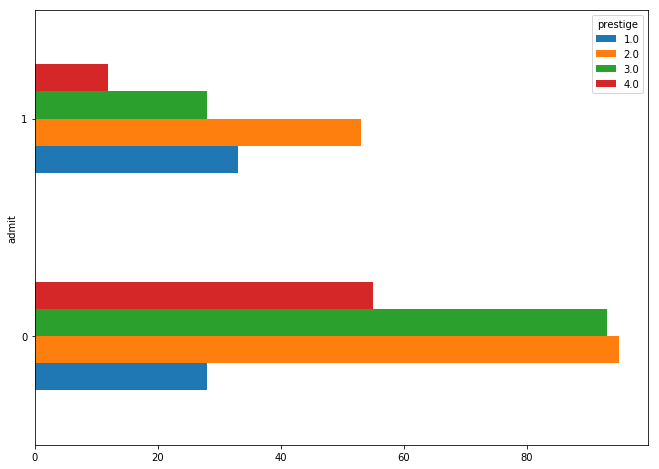

In [17]:
cnts_us.plot.barh(figsize=(11, 8))

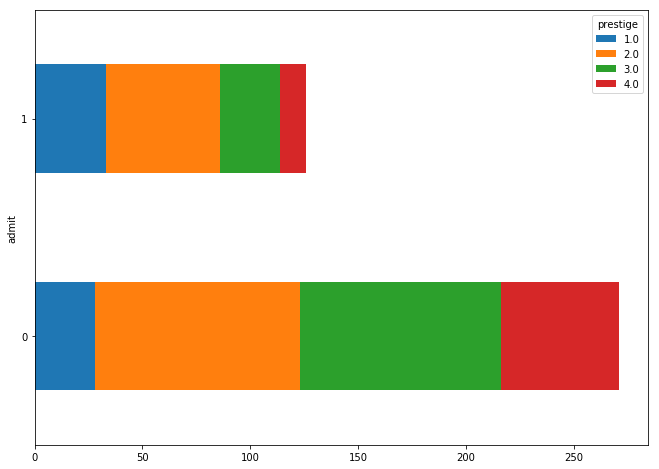

In [18]:
cnts_us.plot.barh(stacked=True, figsize=(11, 8))

In [19]:
cnts["pcnt_of_total"] = cnts / cnts.sum() * 100

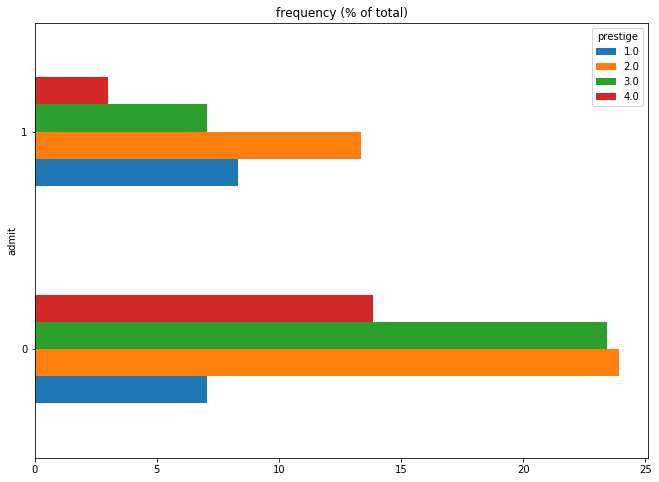

In [20]:
ax = cnts.pcnt_of_total.unstack().plot.barh(figsize=(11, 8))
t = ax.set_title("frequency (% of total)")

In [21]:
cnts["count"].groupby(level=0).sum()

admit
0    271
1    126
Name: count, dtype: int64

In [22]:
cnts["count"].groupby(level=1).sum()

prestige
1.0     61
2.0    148
3.0    121
4.0     67
Name: count, dtype: int64

In [23]:
admit_groups = cnts["count"].groupby(level=0).sum()

In [24]:
admit_groups

admit
0    271
1    126
Name: count, dtype: int64

In [25]:
cnts.loc[0, "count"]

prestige
1.0    28
2.0    95
3.0    93
4.0    55
Name: count, dtype: int64

In [26]:
admit_groups.loc[0]

271

In [27]:
cnts.loc[0, "count"] / admit_groups.loc[0]

prestige
1.0    0.103321
2.0    0.350554
3.0    0.343173
4.0    0.202952
Name: count, dtype: float64

In [28]:
admit_0_pcnts = \
    pd.concat({0: cnts.loc[0, "count"] / admit_groups.loc[0] * 100}, axis=0
             ).rename("pcnt_of_admit"
             ).to_frame()

In [29]:
admit_0_pcnts.index = admit_0_pcnts.index.rename("admit", level=0)

In [30]:
admit_1_pcnts = \
    pd.concat({1: cnts.loc[1, "count"] / admit_groups.loc[1] * 100}, axis=0
             ).rename("pcnt_of_admit"
             ).to_frame()

In [31]:
admit_1_pcnts.index = admit_1_pcnts.index.rename("admit", level=0)

In [32]:
admit_pcnts = pd.concat([admit_0_pcnts, admit_1_pcnts])

In [33]:
admit_pcnts

pcnt_of_admit
admit prestige               
0     1.0           10.332103
      2.0           35.055351
      3.0           34.317343
      4.0           20.295203
1     1.0           26.190476
      2.0           42.063492
      3.0           22.222222
      4.0            9.523810

In [34]:
cnts = cnts.join(admit_pcnts)

In [35]:
cnts

count  pcnt_of_total  pcnt_of_admit
admit prestige                                     
0     1.0          28       7.052897      10.332103
      2.0          95      23.929471      35.055351
      3.0          93      23.425693      34.317343
      4.0          55      13.853904      20.295203
1     1.0          33       8.312343      26.190476
      2.0          53      13.350126      42.063492
      3.0          28       7.052897      22.222222
      4.0          12       3.022670       9.523810

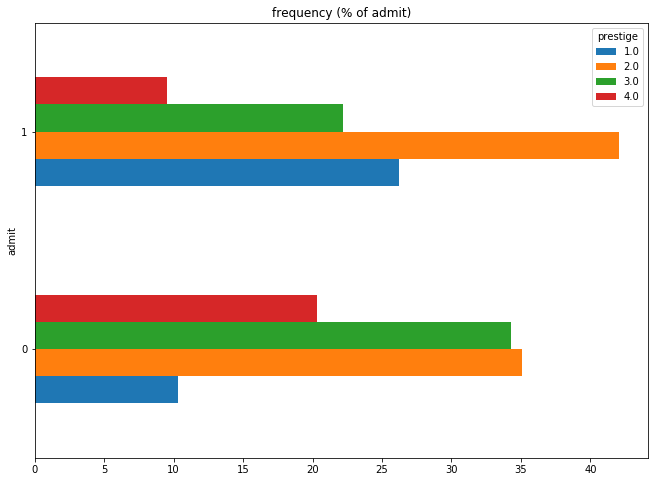

In [36]:
ax = cnts.pcnt_of_admit.unstack().plot.barh(figsize=(11, 8))
t = ax.set_title("frequency (% of admit)")

**the below uses crosstab... not 100% on how it works**

In [37]:
prestige = pd.crosstab(index=df['prestige'], columns='count')
prestige
#pd.crosstab(index=df['prestige'], columns='count').sum()

col_0,count
prestige,
1.0,61
2.0,148
3.0,121
4.0,67


In [38]:
print (prestige.sum(), "\n")   # sum the counts
print (prestige.shape, "\n")   # check number of rows and co
prestige.iloc[2:5]             # slice rows 3-4

col_0
count    397
dtype: int64 

(4, 1) 



col_0,count
prestige,
3.0,121
4.0,67


In [39]:
prestige/prestige.sum()

col_0,count
prestige,
1.0,0.153652
2.0,0.372796
3.0,0.304786
4.0,0.168766


In [40]:
admit = pd.crosstab(index=df['admit'], columns="count")
admit

col_0,count
admit,
0,271
1,126


In [41]:
comb = pd.crosstab(index=df['admit'], columns=df['prestige'])
comb.columns = ['prestige 1','prestige 2','prestige 3','prestige 4']
comb.index= ['admit 0','admit 1']
comb

,prestige 1,prestige 2,prestige 3,prestige 4
admit 0,28,95,93,55
admit 1,33,53,28,12


In [42]:
#you can get the marginal counts (totals for each row and column) by including the argument margins=True:

comb = pd.crosstab(index=df['admit'], columns=df['prestige'], margins=True)
comb.columns = ['prestige 1','prestige 2','prestige 3','prestige 4', 'rowtotal']
comb.index= ['admit 0','admit 1', 'coltotal']
comb

,prestige 1,prestige 2,prestige 3,prestige 4,rowtotal
admit 0,28,95,93,55,271
admit 1,33,53,28,12,126
coltotal,61,148,121,67,397


In [43]:
comb.sum()-comb.loc["coltotal"]

prestige 1     61
prestige 2    148
prestige 3    121
prestige 4     67
rowtotal      397
dtype: int64

In [44]:
#to get the total proportion of counts in each cell, divide the table by the grand total:

comb/comb.loc["coltotal","rowtotal"]

,prestige 1,prestige 2,prestige 3,prestige 4,rowtotal
admit 0,0.070529,0.239295,0.234257,0.138539,0.68262
admit 1,0.083123,0.133501,0.070529,0.030227,0.31738
coltotal,0.153652,0.372796,0.304786,0.168766,1.00000


In [45]:
#to get the proportion of counts along each column (in this case, the admittance rate within each prestige class) divide by the column totals:

comb/comb.loc["coltotal"] 

,prestige 1,prestige 2,prestige 3,prestige 4,rowtotal
admit 0,0.459016,0.641892,0.768595,0.820896,0.68262
admit 1,0.540984,0.358108,0.231405,0.179104,0.31738
coltotal,1.000000,1.000000,1.000000,1.000000,1.00000


In [46]:
#to get the proportion of counts along each row divide by the row totals. 
#the division operator functions on a row-by-row basis when used on DataFrames by default. 
#in this case we want to divide each column by the rowtotals column. 
#to get division to work on a column by column basis, use df.div() with the axis set to 0 (or "index"):

comb.div(comb["rowtotal"], axis=0)

,prestige 1,prestige 2,prestige 3,prestige 4,rowtotal
admit 0,0.103321,0.350554,0.343173,0.202952,1.0
admit 1,0.261905,0.420635,0.222222,0.095238,1.0
coltotal,0.153652,0.372796,0.304786,0.168766,1.0


In [47]:
#alternatively, you can transpose the table with df.T to swap rows and columns and perform row by row division as normal:

comb.T/comb["rowtotal"]

,admit 0,admit 1,coltotal
prestige 1,0.103321,0.261905,0.153652
prestige 2,0.350554,0.420635,0.372796
prestige 3,0.343173,0.222222,0.304786
prestige 4,0.202952,0.095238,0.168766
rowtotal,1.000000,1.000000,1.000000


In [48]:
#the crosstab() function lets you create tables out of more than two categories. 
#higher dimensional tables can be a little confusing to look at, 
#but they can also yield finer-grained insight into interactions between multiple variables:

admit_gre_gpa_prestige = pd.crosstab(index=df['admit'], 
                             columns=[df['prestige'],
                                      df['gpa'],
                                      df['gre']],
                             margins=True)   # Include row and column totals

admit_gre_gpa_prestige

prestige   1.0                                                       ...   \
gpa       2.42  2.55  2.81   2.9  2.91  2.96  2.98        3.02       ...    
gre      680.0 480.0 760.0 340.0 480.0 420.0 460.0 560.0 420.0 480.0 ...    
admit                                                                ...    
0            0     1     0     1     0     1     1     0     1     0 ...    
1            1     0     1     0     1     0     0     1     0     1 ...    
All          1     1     1     1     1     1     1     1     1     1 ...    

prestige   4.0                                                  All  
gpa       3.74  3.77  3.78  3.87  3.88  3.92  3.94  3.95   4.0       
gre      740.0 580.0 540.0 780.0 500.0 420.0 620.0 500.0 800.0       
admit                                                                
0            1     1     1     1     1     1     1     1     1  271  
1            0     0     0     0     0     0     0     0     0  126  
All          1     1     1     1     1     1     1     1     1  397  

[3 rows x 390 columns]

In [49]:
#notice that by passing a second or third variable to the columns argument, 
#the resulting table has columns categorized by both gre, gpa and prestige. 
#the outermost index (prestige) returns sections of the table instead of individual columns:

admit_gre_gpa_prestige[2]        # Get the subtable under prestige 2

gpa    2.42  2.52  2.62        2.63  2.67  2.69  2.70  2.71  2.73  ...   3.95  \
gre   560.0 560.0 480.0 520.0 460.0 480.0 420.0 540.0 500.0 520.0  ...  660.0   
admit                                                              ...          
0         1     1     0     1     1     0     1     1     1     1  ...      0   
1         0     0     1     0     0     1     0     0     0     0  ...      1   
All       1     1     1     1     1     1     1     1     1     1  ...      1   

gpa    3.98  4.00                                            
gre   680.0 480.0 520.0 580.0 620.0 660.0 700.0 780.0 800.0  
admit                                                        
0         0     1     0     1     1     0     1     0     0  
1         1     0     1     0     0     1     0     1     1  
All       1     1     1     1     1     1     1     1     1  

[3 rows x 146 columns]

## Part 2. Return of dummy variables

notes for reference from previous lesson on dummy variables... 

In [ ]:
# set a seed for reproducibility
np.random.seed(12345)

# create a Series of booleans in which roughly half are True
nums = np.random.rand(len(data))
mask_large = nums > 0.5

# initially set Size to small, then change roughly half to be large
data['size'] = 'small'
data.loc[mask_large, 'size'] = 'large'
data.head()

# create a new series called new_ser
data['new_ser'] = data['size'].map({'small':0, 'large':1})
data.head()

In [ ]:
# set a seed for reproducibility
np.random.seed(123456)

# assign roughly one third of observations to each group
nums = np.random.rand(len(data))
mask_suburban = (nums > 0.33) & (nums < 0.66)
mask_urban = nums > 0.66
data['area'] = 'rural'
data.loc[mask_suburban, 'area'] = 'suburban'
data.loc[mask_urban, 'area'] = 'urban'
data.head()

In [53]:
pd.get_dummies(df['prestige']).head()

,1.0,2.0,3.0,4.0
0,0,0,1,0
1,0,0,1,0
2,1,0,0,0
3,0,0,0,1
4,0,0,0,1


In [57]:
pd.get_dummies(df['prestige']).sum(axis=1).describe() 

#axis=1 within the sum, sums across the column. here we see that there is a 1 in at least one column

count    397.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
dtype: float64

In [62]:
# one-hot encoding

# create four dummy variables using get_dummies, then exclude the first dummy column
dummies = pd.get_dummies(df['prestige'], prefix='prestige', drop_first=True)

# UNLESS THE CAtegorical values are mutually exclusive and every row will take on eof these values, you absolutely do NOT drop one of the columns.

# concatenate the dummy variable columns onto the original DataFrame (axis=0 means rows, axis=1 means columns)
#df1 = pd.concat([df, dummies], axis=1)

df1 = df.join(dummies) #defaults to left join

df1.head()

,admit,gre,gpa,prestige,prestige_2.0,prestige_3.0,prestige_4.0
0,0,380.0,3.61,3.0,0,1,0
1,1,660.0,3.67,3.0,0,1,0
2,1,800.0,4.00,1.0,0,0,0
3,1,640.0,3.19,4.0,0,0,1
4,0,520.0,2.93,4.0,0,0,1


#### 2.1 Create class or dummy variables for prestige 

In [63]:
prestige_dummies = pd.get_dummies(df['prestige'])
prestige_dummies.head()

,1.0,2.0,3.0,4.0
0,0,0,1,0
1,0,0,1,0
2,1,0,0,0
3,0,0,0,1
4,0,0,0,1


In [64]:
prestige_dummies.rename(columns={1.0: 'Prestige1', 2.0: 'Prestige2', 3.0: 'Prestige3', 4.0: 'Prestige4'}, inplace=True)
prestige_dummies.head()

,Prestige1,Prestige2,Prestige3,Prestige4
0,0,0,1,0
1,0,0,1,0
2,1,0,0,0
3,0,0,0,1
4,0,0,0,1


#### 2.2 When modeling our class variables, how many do we need? 



Answer: 

3 dummies are needed. when presented with a categorical variable for which every row must take one and exactly one value, you should drop one of the dummy columns so as to avoid redundancy in your exogenous variables (e.g. flip of a coin, you need either heads or tails as a column and do not need both). however if you have a categorical variable for which a row could take multiple or no values, then you leave them all there.

## Part 3. Hand calculating odds ratios

Develop your intuition about expected outcomes by hand calculating odds ratios.

In [65]:
cols_to_keep = ['admit', 'gre', 'gpa']
handcalc = df[cols_to_keep].join(prestige_dummies)
handcalc.head()

,admit,gre,gpa,Prestige1,Prestige2,Prestige3,Prestige4
0,0,380.0,3.61,0,0,1,0
1,1,660.0,3.67,0,0,1,0
2,1,800.0,4.00,1,0,0,0
3,1,640.0,3.19,0,0,0,1
4,0,520.0,2.93,0,0,0,1


In [ ]:
#discovery calcs:

len(handcalc['admit'])
len(handcalc[handcalc['admit']==0])
handcalc['admit'].sum()
len(handcalc[handcalc['Prestige1']==0])
handcalc['Prestige1'].sum()
handcalc['Prestige1'].value_counts()

In [68]:
#it's unclear why the below code returns the columns in the incorrect order, i.e. column 'prestige 4' is really 'prestige 1'?

comb = pd.crosstab(index=handcalc['admit'], columns=[handcalc['Prestige1'],handcalc['Prestige2'],handcalc['Prestige3'],handcalc['Prestige4']], margins=True)
comb.columns = ['prestige 1','prestige 2','prestige 3','prestige 4', 'rowtotal']
comb.index = ['admit 0','admit 1', 'coltotal']
comb

Prestige1   0             1  All
Prestige2   0         1   0     
Prestige3   0    1    0   0     
Prestige4   1    0    0   0     
admit                           
0          55   93   95  28  271
1          12   28   53  33  126
All        67  121  148  61  397

In [67]:
pd.crosstab(df['admit'], df['prestige'], rownames=['admit'])

prestige,1.0,2.0,3.0,4.0
admit,,,,
0,28,95,93,55
1,33,53,28,12


In [69]:
comb = pd.crosstab(index=df['admit'], columns=df['prestige'])
comb.columns = ['prestige 1','prestige 2','prestige 3','prestige 4']
comb.index = ['admit 0','admit 1']
comb

,prestige 1,prestige 2,prestige 3,prestige 4
admit 0,28,95,93,55
admit 1,33,53,28,12


In [70]:
handcalc

,admit,gre,gpa,Prestige1,Prestige2,Prestige3,Prestige4
0,0,380.0,3.61,0,0,1,0
1,1,660.0,3.67,0,0,1,0
2,1,800.0,4.00,1,0,0,0
3,1,640.0,3.19,0,0,0,1
4,0,520.0,2.93,0,0,0,1
5,1,760.0,3.00,0,1,0,0
6,1,560.0,2.98,1,0,0,0
7,0,400.0,3.08,0,1,0,0
8,1,540.0,3.39,0,0,1,0
9,0,700.0,3.92,0,1,0,0


In [71]:
handcalc.describe()

,admit,gre,gpa,Prestige1,Prestige2,Prestige3,Prestige4
count,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000
mean,0.317380,587.858942,3.392242,0.153652,0.372796,0.304786,0.168766
std,0.466044,115.717787,0.380208,0.361070,0.484159,0.460898,0.375017
min,0.000000,220.000000,2.260000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,520.000000,3.130000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,580.000000,3.400000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,660.000000,3.670000,0.000000,1.000000,1.000000,0.000000
max,1.000000,800.000000,4.000000,1.000000,1.000000,1.000000,1.000000


In [72]:
prestige_1 = pd.crosstab(index=handcalc['Prestige1'], columns='count')
prestige_1

col_0,count
Prestige1,
0,336
1,61


In [73]:
admit = pd.crosstab(index=handcalc['admit'], columns='count')
admit

col_0,count
admit,
0,271
1,126


In [74]:
# crosstab 'prestige 1' admission, indexed by 'admit'
# frequency table cutting prestige and whether or not someone was admitted
comb1 = pd.crosstab(index=handcalc['admit'], columns=handcalc['Prestige1'])
comb1.columns = ['not prestige 1', 'prestige 1'] #what determines the order for the column names?
comb1.index = ['admit 0','admit 1']
comb1

,not prestige 1,prestige 1
admit 0,243,28
admit 1,93,33


In [75]:
# crosstab 'prestige 1' admission, indexed by 'prestige 1'
# frequency table cutting prestige and whether or not someone was admitted
comb2 = pd.crosstab(index=handcalc['Prestige1'], columns=handcalc['admit'])
comb2.columns = ['admit 0','admit 1'] 
comb2.index = ['not prestige 1', 'prestige 1'] #what determines the order for the column names?
comb2

,admit 0,admit 1
not prestige 1,243,93
prestige 1,28,33


In [76]:
comb3 = pd.crosstab(handcalc['admit'], handcalc['Prestige1'], rownames=['admit'], colnames=['Prestige1'])
comb3

Prestige1,0,1
admit,,
0,243,28
1,93,33


In [77]:
comb4 = pd.crosstab(handcalc['Prestige1'], handcalc['admit'], rownames=['Prestige1'], colnames=['admit'])
comb4

admit,0,1
Prestige1,,
0,243,93
1,28,33


#### 3.1 Use the cross tab above to calculate the odds of being admitted to grad school if you attended a #1 ranked college

In [78]:
comb4.iloc[1][1] / (comb4.iloc[1].sum() - comb4.iloc[1][1])

1.1785714285714286

odds ratio:  33:28

In [111]:
33/(33+28)

0.5409836065573771

In [79]:
comb1

,not prestige 1,prestige 1
admit 0,243,28
admit 1,93,33


In [80]:
comb1['prestige 1']

admit 0    28
admit 1    33
Name: prestige 1, dtype: int64

In [81]:
comb1['not prestige 1']

admit 0    243
admit 1     93
Name: not prestige 1, dtype: int64

In [89]:
comb1

,not prestige 1,prestige 1
admit 0,243,28
admit 1,93,33


In [96]:
comb1['prestige 1']['admit 1']
 

33

In [95]:
comb1['prestige 1']['admit 0']

28

#### 3.2 Now calculate the odds of admission if you did not attend a #1 ranked college

In [99]:
comb4

admit,0,1
Prestige1,,
0,243,93
1,28,33


In [105]:
comb4.iloc[0, 1]

93

In [107]:
comb4.loc[0, 1] #if teh index were named anything but 0, it would kick back an error

93

In [101]:
93+243

336

In [102]:
comb4.iloc[0][1] / (comb4.iloc[0].sum() - comb4.iloc[0][1])

0.38271604938271603

In [112]:
93/(93+243)

0.2767857142857143

#### 3.3 Calculate the odds ratio

odds ratio:  93:243

#### 3.4 Write this finding in a sentenance: 

Answer: 

#### 3.5 Print the cross tab for prestige_4

In [108]:
comb5 = pd.crosstab(handcalc['Prestige4'], handcalc['admit'], rownames=['Prestige4'], colnames=['admit'])
comb5

admit,0,1
Prestige4,,
0,216,114
1,55,12


#### 3.6 Calculate the Odds Ratio 

12:55

In [109]:
12/(67-12)

0.21818181818181817

In [114]:
12/(12+67)

0.1518987341772152

#### 3.7 Write this finding in a sentence

Answer:

## Part 4. Analysis

In [115]:
prestige_dummies.iloc[:, 1:] #the first section in [] is rows, and the second section is columns

,Prestige2,Prestige3,Prestige4
0,0,1,0
1,0,1,0
2,0,0,0
3,0,0,1
4,0,0,1
5,1,0,0
6,0,0,0
7,1,0,0
8,0,1,0
9,1,0,0


In [116]:
# create a clean data frame for the regression
cols_to_keep = ['admit', 'gre', 'gpa']

# Dropping one of the dummy columns
data = df[cols_to_keep].join(prestige_dummies.iloc[:, 1:]) #the first section in [] is rows, and the second section is columns
data.head()

,admit,gre,gpa,Prestige2,Prestige3,Prestige4
0,0,380.0,3.61,0,1,0
1,1,660.0,3.67,0,1,0
2,1,800.0,4.00,0,0,0
3,1,640.0,3.19,0,0,1
4,0,520.0,2.93,0,0,1


#### if using statsmodel

We will add a constant term for our Logistic Regression. 

The statsmodels function requires that intercepts/constants are specified explicitly.

make sure to come back to this with Abe.

In [ ]:
#have not pulled in stats model for the regression...

# manually add the intercept
#data['intercept'] = 1.0

#### 4.1 Create the X and Y variables

In [117]:
feature_cols = ['gre', 'gpa', 'Prestige2', 'Prestige3', 'Prestige4']
X = data[feature_cols] #create X (we are passing a list of arrays, so we don't need to use double [[]] to ensure it reads as a df)
y = data['admit']  #create y

#### 4.2 Fit the model - 

 - Load sklearn's logistic regression
 - Create the regression object
 - Fit the model

In [120]:
#fitting a logistic regression model and storing the class predictions

from sklearn.linear_model import LogisticRegression #load sklearn's logistic regression

logreg = LogisticRegression() #create regression object/instantiate the model

logreg.fit(X, y) #fit
pred = logreg.predict(X) #predict

logreg.score(X, y) #this returns the accuracy

0.7052896725440806

#### 4.3 Print the coefficients

In [121]:
print (logreg.coef_)
print (logreg.intercept_) #note, this is the internal intercept that gets fed into the logistic regression 
print (df.admit.mean())

[[ 0.00178497  0.23229458 -0.60347467 -1.17214957 -1.37729795]]
[-1.81701706]
0.31738035264483627


- if you throw zero 0 for all the y pred's, you would be right 68% of the time, that is not very good
- if you throw 1 for all the y pred's, you would be right 32% of the time, that is not very good

In [127]:
df.admit.mean()

0.31738035264483627

In [128]:
admit_perc = 126 / (271+126)
admit_perc

0.31738035264483627

In [131]:
print(pred) #this is the predicton, based on a default of .5

# if the model outputs .49 you are not getting in , if it outputs .51, you are getting in 

[0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [132]:
proba = logreg.predict_proba(X) #predict

In [142]:
proba[:5] # the first one will always be the probability of not what you are trying to predict, and the second what you are trying to predict

array([[0.81340581, 0.18659419],
       [0.72283424, 0.27716576],
       [0.36815534, 0.63184466],
       [0.78766596, 0.21233404],
       [0.82998297, 0.17001703]])

In [141]:
print(proba[:, 1])

[0.18659419 0.27716576 0.63184466 0.21233404 0.17001703 0.40925899
 0.46874205 0.27070755 0.22481859 0.43526125 0.3021334  0.42956137
 0.61508543 0.38804338 0.58943772 0.2086162  0.28842267 0.14780737
 0.4696848  0.50797682 0.20419042 0.40150911 0.18720704 0.2245205
 0.42905043 0.61328896 0.53201833 0.19823728 0.43039855 0.46889457
 0.20548533 0.2985104  0.24445981 0.3470547  0.39054492 0.26933392
 0.49330638 0.19983482 0.30982793 0.1917883  0.29759959 0.35114953
 0.35028634 0.20952587 0.38034939 0.20315947 0.35859467 0.16632301
 0.13790066 0.18287472 0.27885915 0.15685126 0.2515047  0.39004865
 0.26207308 0.32319895 0.22294903 0.16411395 0.29762611 0.18720704
 0.36005798 0.19411147 0.27007075 0.29295988 0.26411199 0.37388842
 0.26259399 0.51405567 0.51884944 0.61713824 0.28544585 0.12126306
 0.17507905 0.38792808 0.24829637 0.31543981 0.22986517 0.3470547
 0.46795069 0.55449361 0.21905523 0.35419158 0.2893614  0.13704555
 0.22090155 0.31001084 0.35932599 0.36792625 0.54844488 0.422326

In [143]:
from sklearn.metrics import precision_score as ps
from sklearn.metrics import recall_score as rc
from sklearn.metrics import confusion_matrix as cm

In [148]:
ps(y, pred) # this gives the precision

# true postive / (true postive + false positive)

# precision speaks to how careful ytour model is

# the group you identified correctly divided by the total group you identified

# this number should be as high as possible

# you won't cover your outdoor furniture unless it's a crazy hurricane, you're only doing it when it really counts

# e.g. very expensive advertising: banner on the highway you are going for recall, a very expensive dinner with high likely converting clients is going for precision, or is optiomizing for recall

0.6216216216216216

In [149]:
rc(y, pred) #this gives the recall

#true postive / (true postive + false negative) 

#the group you identified correctly divided by the group total

#this number should be as high as possible

#for cases like cancer, you want to have a better recall and minimize the chance for false negatives

0.18253968253968253

In [150]:
cm(y, pred) #this gives the confusion matrix, which is easier to read with labels

array([[257,  14],
       [103,  23]])

In [151]:
23 / (14+23) 

#precision
#23 is the true positive predicted correctly 
#14 is the false positive, precicted as admitted but they are not actually admitted

0.6216216216216216

In [152]:
23 / (23+103)

#recall
#23 is the true positive predicted correctly 
#103 is the false negative, precicted as not admitted but they are actually admitted

0.18253968253968253

#### 4.4 Calculate the odds ratios of the coeffiencents

hint 1: np.exp(X)

#### (from original project)

hint 2: conf['OR'] = params
        
           conf.columns = ['2.5%', '97.5%', 'OR']

- odds = probability / (1 - probability) i.e. one specific outcome/the rest of the other outcomes
- probability = odds / (1 + odds) i.e. one specific outcome/all outcomes

- logistic regression, compresses the linear reression to fit between 0 and 1 ???
- the np.exp(X) reverts it back ???

In [153]:
logreg.coef_ #this is a list of a list, which is why you need to index into it

array([[ 0.00178497,  0.23229458, -0.60347467, -1.17214957, -1.37729795]])

In [154]:
#logodds = logreg.intercept_ + logreg.coef_[0] * ???
#logodds

In [155]:
#this gives the odds ratio
params = logreg.coef_[0]
np.exp(params)

array([1.00178657, 1.26149128, 0.546908  , 0.3097005 , 0.25225925])

In [156]:
# Convert log odds to odds.
odds = np.exp(params)
odds

array([1.00178657, 1.26149128, 0.546908  , 0.3097005 , 0.25225925])

In [157]:
# Convert odds to probability.
prob = odds/(1 + odds)
prob

array([0.50044624, 0.5578139 , 0.35354915, 0.23646666, 0.20144331])

#### 4.5 Interpret the OR of Prestige_2

http://www.biochemia-medica.com/content/odds-ratio-calculation-usage-and-interpretation

Answer: 

- ppl who went to prestige 2 school, are 54% more likely to get admitted than prestige 1 students 
- bc prestige 1 is the dummy variable, or your base

#### 4.6 Interpret the OR of GPA

Answer: 

- for one unit increase in gpage you are 1.26149128 times to be admitted

## Bonus

Plot the probability of being admitted into graduate school, stratified by GPA and GRE score.



**(from original project - not part of current project)**

## Part 5: Predicted probablities

As a way of evaluating our classifier, we're going to recreate the dataset with every logical combination of input values. This will allow us to see how the predicted probability of admission increases/decreases across different variables. First we're going to generate the combinations using a helper function called cartesian (above).

We're going to use np.linspace to create a range of values for "gre" and "gpa". This creates a range of linearly spaced values from a specified min and maximum value--in our case just the min/max observed values.

In [ ]:
def cartesian(arrays, out=None):
    """
    Generate a cartesian product of input arrays.
    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.
    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.
    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])
    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n / arrays[0].size
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out

In [ ]:
# instead of generating all possible values of GRE and GPA, we're going
# to use an evenly spaced range of 10 values from the min to the max 
gres = np.linspace(data['gre'].min(), data['gre'].max(), 10)
print (gres)
# array([ 220.        ,  284.44444444,  348.88888889,  413.33333333,
#         477.77777778,  542.22222222,  606.66666667,  671.11111111,
#         735.55555556,  800.        ])
gpas = np.linspace(data['gpa'].min(), data['gpa'].max(), 10)
print (gpas)
# array([ 2.26      ,  2.45333333,  2.64666667,  2.84      ,  3.03333333,
#         3.22666667,  3.42      ,  3.61333333,  3.80666667,  4.        ])


# enumerate all possibilities
combos = pd.DataFrame(cartesian([gres, gpas, [1, 2, 3, 4], [1.]]))

#### 5.1 Recreate the dummy variables

In [ ]:
# recreate the dummy variables

# keep only what we need for making predictions

#### 5.2 Make predictions on the enumerated dataset

#### 5.3 Interpret findings for the last 4 observations